In [1]:
from jupyterthemes import jtplot
from tensorflow import set_random_seed
set_random_seed(42)
jtplot.style()
# Constantes
SEED = 42
SIGMA = 0.15
m = 64
tau = 1
delta = 1
NUMREP = 2

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from keras import regularizers
from tensorflow import keras
import numpy as np
import pandas as pd
np.random.seed(7)

Using TensorFlow backend.


In [3]:
from Funciones import GenersConjuntos
from Funciones import plot_history

In [4]:
def ModMLP(show=True): # Modelo de la red neuronal a utilizar
    inputs = keras.Input(shape=(m))
    x = layers.Dense(64, activation='sigmoid')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(delta, activation='linear')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='forecasting')
    
    if(show):
        model.summary()
    
    return model

<h3> Lectura y analisis de la serie de tiempo </h3>

Para comenzar se lee la serie de tiempo desde el archivo csv

In [5]:
TS = pd.read_csv('TimesSeries\Electric_Production.csv')

In [6]:
TS.info() # Se reviza que la serie de tiempo no tenga nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
DATE     397 non-null object
Value    397 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


La serie de tiempo es tomada desde la columna value

In [7]:
serie = TS.Value
mean = serie.mean()
std = serie.std()
serie.shape

(397,)

Se pueden revizar su media, su maximo, su minimo, y su promedio

In [8]:
print('Media:', serie.mean())
print('Maximo:', serie.max())
print('Minimo:', serie.min())
print('STD:', serie.std())

Media: 88.84721763224182
Maximo: 129.4048
Minimo: 55.3151
STD: 15.387833664730902


La serie es convertiza a numpy array para un mejor manejo, a su vez es ploteada para observar su forma

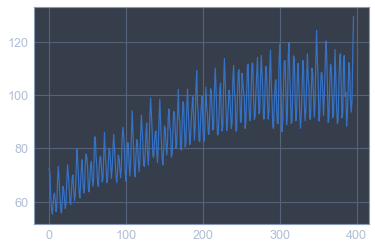

In [9]:
serie = np.array(serie)
plt.plot(serie)
plt.show()

Posteriormente se estandariza la serie y se obtienen los conjuntos de datos con los cuales se ha de entrenar la red

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test=  GenersConjuntos(serie, 0.3, 0.2)

In [11]:
X_val.shape

(47, 64)

<h3> Añadir ruido al train_set </h3>

En esta sección del documento se muestra como se añade ruido al conjunto de entrenamiento, comenzando con la  función addNoise la cual recibe el conjunto de entrenamiento el numero de muestras aleatorias (rep) la media, sigma, y la i que es el indice del nuevo arreglo

In [12]:
def addNoise(train_set, rep, mean, sigma, i):
    i = int(i/rep)
    
    l = len(train_set[0])
    e = np.random.normal(mean, sigma, size=(l))
    Nueva_muestra = train_set[i,:] + e
    
    return Nueva_muestra

In [13]:
def returnTarget(y_train, rep, i):
    i = int(i/rep)
    return y_train[i]
    

In [14]:
print(addNoise(X_train, NUMREP, 0, SIGMA,1))

[ 0.68675762  0.77258796  0.74379316  0.39797243 -0.20429497  0.05022917
  1.09816145  1.18873966  0.99413172  0.74786968 -0.24800159 -0.13139147
  0.76944901  1.22981803  1.30653335  0.45015457  0.14236562  0.12343873
  1.30209597  0.78772705  1.07217669  0.64484528 -0.14512716  0.38081506
  0.75300776  1.22061056  1.41444561  0.10676469  0.25674177  0.16587877
  0.8138105   1.67113314  1.24843589  0.75346545 -0.18144607  0.10964214
  0.608021    1.43746688  1.90831671  0.7759405   0.39676739  0.3025984
  1.25029701  1.5779344   1.00530076  0.48376799  0.19718201  0.49249544
  1.02365279  1.34734087  1.50483672  0.61282248  0.15515657  0.36052721
  1.31891825  1.77447774  0.79806464  0.66122903 -0.05650542  0.09368309
  0.49069762  0.69406468  1.08480444  0.64762379]


In [15]:
# Se genera el nuevo conjunto de entrenamiento
X_train_e =  [addNoise(X_train, NUMREP, 0, SIGMA,i)
               for i in range(len(X_train)*NUMREP)
             ]
y_train_e = [returnTarget(y_train, NUMREP, i)
               for i in range(len(X_train)*NUMREP)
             ]
# Como el nuevo conjunto es una lista se pasa a numpy array
X_train_e = np.array(X_train_e)
y_train_e = np.array(y_train_e)
print(X_train_e.shape)
print('Media:', X_train_e.mean())
print('Maximo:', X_train_e.max())
print('Minimo:', X_train_e.min())
print('STD:', X_train.std())

print('\n##########################\n')

print('Media:', X_train.mean())
print('Maximo:', X_train.max())
print('Minimo:', X_train.min())
print('STD:', X_train.std())


(372, 64)
Media: 0.06523972916191324
Maximo: 2.608498248913499
Minimo: -2.5329215617462904
STD: 0.9013609705163935

##########################

Media: 0.06635958624690474
Maximo: 2.3039215019814105
Minimo: -2.1818814916347007
STD: 0.9013609705163935


<h3> Diseño y entrenamiento de la red neuronal </h3>

In [16]:
model = ModMLP()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "forecasting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 45,761
Trainable params: 45,761
Non-trainable params: 0
_________________________________________________________________


In [17]:
X_val.shape

(47, 64)

Una vez que el modelo esta creado se compila y se entrena.

En la compilación se utiliza como funcion de perdida el Error cuadratico medio en convinacion con el gradiente estocastico, el tercer parametro son las metricas en este caso se utilizan el error absoluto medio, el error cuadratico medio y accuracy, aunque la ultima no es una buena referencia cuando se realiza prediccion de series de tiempo (forcasting) es más comun su utilización en clasificación.

In [18]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae', 'mse','accuracy'])

In [19]:
#callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_e, y_train_e,
                    batch_size=64,
                    #callbacks=[callback],
                    epochs=1000,
                    validation_data=(X_val, y_val))

test_scores = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])
print('Test mse:', test_scores[2])
print('Test acc:', test_scores[3])

Train on 372 samples, validate on 47 samples
Epoch 1/1000
372/372 [==============================] - 1s 2ms/sample - loss: 0.5745 - mean_absolute_error: 0.6077 - mean_squared_error: 0.5745 - acc: 0.0000e+00 - val_loss: 0.3144 - val_mean_absolute_error: 0.4778 - val_mean_squared_error: 0.3144 - val_acc: 0.0000e+00
Epoch 2/1000
372/372 [==============================] - 0s 131us/sample - loss: 0.4042 - mean_absolute_error: 0.5263 - mean_squared_error: 0.4042 - acc: 0.0000e+00 - val_loss: 0.2350 - val_mean_absolute_error: 0.4180 - val_mean_squared_error: 0.2350 - val_acc: 0.0000e+00
Epoch 3/1000
372/372 [==============================] - 0s 113us/sample - loss: 0.3230 - mean_absolute_error: 0.4756 - mean_squared_error: 0.3230 - acc: 0.0000e+00 - val_loss: 0.1829 - val_mean_absolute_error: 0.3696 - val_mean_squared_error: 0.1829 - val_acc: 0.0000e+00
Epoch 4/1000
372/372 [==============================] - 0s 142us/sample - loss: 0.2746 - mean_absolute_error: 0.4377 - mean_squared_error: 0.

Epoch 31/1000
372/372 [==============================] - 0s 123us/sample - loss: 0.0541 - mean_absolute_error: 0.1816 - mean_squared_error: 0.0541 - acc: 0.0000e+00 - val_loss: 0.0370 - val_mean_absolute_error: 0.1525 - val_mean_squared_error: 0.0370 - val_acc: 0.0000e+00
Epoch 32/1000
372/372 [==============================] - 0s 158us/sample - loss: 0.0545 - mean_absolute_error: 0.1804 - mean_squared_error: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0383 - val_mean_absolute_error: 0.1545 - val_mean_squared_error: 0.0383 - val_acc: 0.0000e+00
Epoch 33/1000
372/372 [==============================] - 0s 150us/sample - loss: 0.0525 - mean_absolute_error: 0.1783 - mean_squared_error: 0.0525 - acc: 0.0000e+00 - val_loss: 0.0371 - val_mean_absolute_error: 0.1535 - val_mean_squared_error: 0.0371 - val_acc: 0.0000e+00
Epoch 34/1000
372/372 [==============================] - 0s 123us/sample - loss: 0.0523 - mean_absolute_error: 0.1770 - mean_squared_error: 0.0523 - acc: 0.0000e+00 - val_loss: 0.03

372/372 [==============================] - 0s 147us/sample - loss: 0.0455 - mean_absolute_error: 0.1618 - mean_squared_error: 0.0455 - acc: 0.0000e+00 - val_loss: 0.0453 - val_mean_absolute_error: 0.1685 - val_mean_squared_error: 0.0453 - val_acc: 0.0000e+00
Epoch 62/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0483 - mean_absolute_error: 0.1654 - mean_squared_error: 0.0483 - acc: 0.0000e+00 - val_loss: 0.0440 - val_mean_absolute_error: 0.1660 - val_mean_squared_error: 0.0440 - val_acc: 0.0000e+00
Epoch 63/1000
372/372 [==============================] - 0s 107us/sample - loss: 0.0479 - mean_absolute_error: 0.1666 - mean_squared_error: 0.0479 - acc: 0.0000e+00 - val_loss: 0.0366 - val_mean_absolute_error: 0.1521 - val_mean_squared_error: 0.0366 - val_acc: 0.0000e+00
Epoch 64/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0453 - mean_absolute_error: 0.1606 - mean_squared_error: 0.0453 - acc: 0.0000e+00 - val_loss: 0.0365 - val_mean_a

372/372 [==============================] - 0s 97us/sample - loss: 0.0426 - mean_absolute_error: 0.1545 - mean_squared_error: 0.0426 - acc: 0.0000e+00 - val_loss: 0.0369 - val_mean_absolute_error: 0.1524 - val_mean_squared_error: 0.0369 - val_acc: 0.0000e+00
Epoch 92/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0429 - mean_absolute_error: 0.1570 - mean_squared_error: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0363 - val_mean_absolute_error: 0.1511 - val_mean_squared_error: 0.0363 - val_acc: 0.0000e+00
Epoch 93/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0429 - mean_absolute_error: 0.1543 - mean_squared_error: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0323 - val_mean_absolute_error: 0.1420 - val_mean_squared_error: 0.0323 - val_acc: 0.0000e+00
Epoch 94/1000
372/372 [==============================] - 0s 115us/sample - loss: 0.0414 - mean_absolute_error: 0.1524 - mean_squared_error: 0.0414 - acc: 0.0000e+00 - val_loss: 0.0325 - val_mean_a

372/372 [==============================] - 0s 102us/sample - loss: 0.0399 - mean_absolute_error: 0.1495 - mean_squared_error: 0.0399 - acc: 0.0000e+00 - val_loss: 0.0340 - val_mean_absolute_error: 0.1450 - val_mean_squared_error: 0.0340 - val_acc: 0.0000e+00
Epoch 122/1000
372/372 [==============================] - 0s 121us/sample - loss: 0.0390 - mean_absolute_error: 0.1478 - mean_squared_error: 0.0390 - acc: 0.0000e+00 - val_loss: 0.0308 - val_mean_absolute_error: 0.1382 - val_mean_squared_error: 0.0308 - val_acc: 0.0000e+00
Epoch 123/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0392 - mean_absolute_error: 0.1485 - mean_squared_error: 0.0392 - acc: 0.0000e+00 - val_loss: 0.0314 - val_mean_absolute_error: 0.1388 - val_mean_squared_error: 0.0314 - val_acc: 0.0000e+00
Epoch 124/1000
372/372 [==============================] - 0s 91us/sample - loss: 0.0406 - mean_absolute_error: 0.1507 - mean_squared_error: 0.0406 - acc: 0.0000e+00 - val_loss: 0.0366 - val_mean

Epoch 151/1000
372/372 [==============================] - 0s 107us/sample - loss: 0.0377 - mean_absolute_error: 0.1447 - mean_squared_error: 0.0377 - acc: 0.0000e+00 - val_loss: 0.0335 - val_mean_absolute_error: 0.1427 - val_mean_squared_error: 0.0335 - val_acc: 0.0000e+00
Epoch 152/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0374 - mean_absolute_error: 0.1442 - mean_squared_error: 0.0374 - acc: 0.0000e+00 - val_loss: 0.0307 - val_mean_absolute_error: 0.1362 - val_mean_squared_error: 0.0307 - val_acc: 0.0000e+00
Epoch 153/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0371 - mean_absolute_error: 0.1439 - mean_squared_error: 0.0371 - acc: 0.0000e+00 - val_loss: 0.0306 - val_mean_absolute_error: 0.1359 - val_mean_squared_error: 0.0306 - val_acc: 0.0000e+00
Epoch 154/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0371 - mean_absolute_error: 0.1436 - mean_squared_error: 0.0371 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 181/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0361 - mean_absolute_error: 0.1416 - mean_squared_error: 0.0361 - acc: 0.0000e+00 - val_loss: 0.0281 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0281 - val_acc: 0.0000e+00
Epoch 182/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0364 - mean_absolute_error: 0.1429 - mean_squared_error: 0.0364 - acc: 0.0000e+00 - val_loss: 0.0351 - val_mean_absolute_error: 0.1465 - val_mean_squared_error: 0.0351 - val_acc: 0.0000e+00
Epoch 183/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0356 - mean_absolute_error: 0.1407 - mean_squared_error: 0.0356 - acc: 0.0000e+00 - val_loss: 0.0290 - val_mean_absolute_error: 0.1323 - val_mean_squared_error: 0.0290 - val_acc: 0.0000e+00
Epoch 184/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0359 - mean_absolute_error: 0.1418 - mean_squared_error: 0.0359 - acc: 0.0000e+00 - val_loss: 0.

Epoch 211/1000
372/372 [==============================] - 0s 101us/sample - loss: 0.0345 - mean_absolute_error: 0.1389 - mean_squared_error: 0.0345 - acc: 0.0000e+00 - val_loss: 0.0280 - val_mean_absolute_error: 0.1299 - val_mean_squared_error: 0.0280 - val_acc: 0.0000e+00
Epoch 212/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0348 - mean_absolute_error: 0.1392 - mean_squared_error: 0.0348 - acc: 0.0000e+00 - val_loss: 0.0281 - val_mean_absolute_error: 0.1302 - val_mean_squared_error: 0.0281 - val_acc: 0.0000e+00
Epoch 213/1000
372/372 [==============================] - 0s 98us/sample - loss: 0.0347 - mean_absolute_error: 0.1396 - mean_squared_error: 0.0347 - acc: 0.0000e+00 - val_loss: 0.0276 - val_mean_absolute_error: 0.1303 - val_mean_squared_error: 0.0276 - val_acc: 0.0000e+00
Epoch 214/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0346 - mean_absolute_error: 0.1392 - mean_squared_error: 0.0346 - acc: 0.0000e+00 - val_loss: 0

Epoch 241/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0338 - mean_absolute_error: 0.1378 - mean_squared_error: 0.0338 - acc: 0.0000e+00 - val_loss: 0.0270 - val_mean_absolute_error: 0.1288 - val_mean_squared_error: 0.0270 - val_acc: 0.0000e+00
Epoch 242/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0339 - mean_absolute_error: 0.1368 - mean_squared_error: 0.0339 - acc: 0.0000e+00 - val_loss: 0.0297 - val_mean_absolute_error: 0.1328 - val_mean_squared_error: 0.0297 - val_acc: 0.0000e+00
Epoch 243/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0337 - mean_absolute_error: 0.1372 - mean_squared_error: 0.0337 - acc: 0.0000e+00 - val_loss: 0.0296 - val_mean_absolute_error: 0.1321 - val_mean_squared_error: 0.0296 - val_acc: 0.0000e+00
Epoch 244/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0340 - mean_absolute_error: 0.1372 - mean_squared_error: 0.0340 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 271/1000
372/372 [==============================] - 0s 131us/sample - loss: 0.0333 - mean_absolute_error: 0.1377 - mean_squared_error: 0.0333 - acc: 0.0000e+00 - val_loss: 0.0271 - val_mean_absolute_error: 0.1272 - val_mean_squared_error: 0.0271 - val_acc: 0.0000e+00
Epoch 272/1000
372/372 [==============================] - 0s 147us/sample - loss: 0.0327 - mean_absolute_error: 0.1349 - mean_squared_error: 0.0327 - acc: 0.0000e+00 - val_loss: 0.0264 - val_mean_absolute_error: 0.1280 - val_mean_squared_error: 0.0264 - val_acc: 0.0000e+00
Epoch 273/1000
372/372 [==============================] - 0s 134us/sample - loss: 0.0329 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0329 - acc: 0.0000e+00 - val_loss: 0.0273 - val_mean_absolute_error: 0.1274 - val_mean_squared_error: 0.0273 - val_acc: 0.0000e+00
Epoch 274/1000
372/372 [==============================] - 0s 129us/sample - loss: 0.0326 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0326 - acc: 0.0000e+00 - val_loss: 

Epoch 301/1000
372/372 [==============================] - 0s 118us/sample - loss: 0.0322 - mean_absolute_error: 0.1334 - mean_squared_error: 0.0322 - acc: 0.0000e+00 - val_loss: 0.0289 - val_mean_absolute_error: 0.1292 - val_mean_squared_error: 0.0289 - val_acc: 0.0000e+00
Epoch 302/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0317 - mean_absolute_error: 0.1328 - mean_squared_error: 0.0317 - acc: 0.0000e+00 - val_loss: 0.0271 - val_mean_absolute_error: 0.1270 - val_mean_squared_error: 0.0271 - val_acc: 0.0000e+00
Epoch 303/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0316 - mean_absolute_error: 0.1325 - mean_squared_error: 0.0316 - acc: 0.0000e+00 - val_loss: 0.0264 - val_mean_absolute_error: 0.1273 - val_mean_squared_error: 0.0264 - val_acc: 0.0000e+00
Epoch 304/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0316 - mean_absolute_error: 0.1333 - mean_squared_error: 0.0316 - acc: 0.0000e+00 - val_loss: 

Epoch 331/1000
372/372 [==============================] - 0s 117us/sample - loss: 0.0323 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0323 - acc: 0.0000e+00 - val_loss: 0.0291 - val_mean_absolute_error: 0.1334 - val_mean_squared_error: 0.0291 - val_acc: 0.0000e+00
Epoch 332/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0314 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0314 - acc: 0.0000e+00 - val_loss: 0.0288 - val_mean_absolute_error: 0.1293 - val_mean_squared_error: 0.0288 - val_acc: 0.0000e+00
Epoch 333/1000
372/372 [==============================] - 0s 118us/sample - loss: 0.0324 - mean_absolute_error: 0.1356 - mean_squared_error: 0.0324 - acc: 0.0000e+00 - val_loss: 0.0284 - val_mean_absolute_error: 0.1285 - val_mean_squared_error: 0.0284 - val_acc: 0.0000e+00
Epoch 334/1000
372/372 [==============================] - 0s 115us/sample - loss: 0.0308 - mean_absolute_error: 0.1312 - mean_squared_error: 0.0308 - acc: 0.0000e+00 - val_loss: 

Epoch 361/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0305 - mean_absolute_error: 0.1313 - mean_squared_error: 0.0305 - acc: 0.0000e+00 - val_loss: 0.0289 - val_mean_absolute_error: 0.1295 - val_mean_squared_error: 0.0289 - val_acc: 0.0000e+00
Epoch 362/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0324 - mean_absolute_error: 0.1345 - mean_squared_error: 0.0324 - acc: 0.0000e+00 - val_loss: 0.0261 - val_mean_absolute_error: 0.1269 - val_mean_squared_error: 0.0261 - val_acc: 0.0000e+00
Epoch 363/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0308 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0308 - acc: 0.0000e+00 - val_loss: 0.0260 - val_mean_absolute_error: 0.1247 - val_mean_squared_error: 0.0260 - val_acc: 0.0000e+00
Epoch 364/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0307 - mean_absolute_error: 0.1313 - mean_squared_error: 0.0307 - acc: 0.0000e+00 - val_loss: 0

Epoch 391/1000
372/372 [==============================] - 0s 123us/sample - loss: 0.0295 - mean_absolute_error: 0.1293 - mean_squared_error: 0.0295 - acc: 0.0000e+00 - val_loss: 0.0260 - val_mean_absolute_error: 0.1244 - val_mean_squared_error: 0.0260 - val_acc: 0.0000e+00
Epoch 392/1000
372/372 [==============================] - 0s 126us/sample - loss: 0.0293 - mean_absolute_error: 0.1274 - mean_squared_error: 0.0293 - acc: 0.0000e+00 - val_loss: 0.0276 - val_mean_absolute_error: 0.1262 - val_mean_squared_error: 0.0276 - val_acc: 0.0000e+00
Epoch 393/1000
372/372 [==============================] - 0s 126us/sample - loss: 0.0305 - mean_absolute_error: 0.1326 - mean_squared_error: 0.0305 - acc: 0.0000e+00 - val_loss: 0.0279 - val_mean_absolute_error: 0.1278 - val_mean_squared_error: 0.0279 - val_acc: 0.0000e+00
Epoch 394/1000
372/372 [==============================] - 0s 115us/sample - loss: 0.0293 - mean_absolute_error: 0.1279 - mean_squared_error: 0.0293 - acc: 0.0000e+00 - val_loss: 

Epoch 421/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0300 - mean_absolute_error: 0.1298 - mean_squared_error: 0.0300 - acc: 0.0000e+00 - val_loss: 0.0261 - val_mean_absolute_error: 0.1236 - val_mean_squared_error: 0.0261 - val_acc: 0.0000e+00
Epoch 422/1000
372/372 [==============================] - 0s 118us/sample - loss: 0.0302 - mean_absolute_error: 0.1300 - mean_squared_error: 0.0302 - acc: 0.0000e+00 - val_loss: 0.0283 - val_mean_absolute_error: 0.1272 - val_mean_squared_error: 0.0283 - val_acc: 0.0000e+00
Epoch 423/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0303 - mean_absolute_error: 0.1304 - mean_squared_error: 0.0303 - acc: 0.0000e+00 - val_loss: 0.0273 - val_mean_absolute_error: 0.1250 - val_mean_squared_error: 0.0273 - val_acc: 0.0000e+00
Epoch 424/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0287 - mean_absolute_error: 0.1266 - mean_squared_error: 0.0287 - acc: 0.0000e+00 - val_loss: 0

Epoch 451/1000
372/372 [==============================] - 0s 94us/sample - loss: 0.0288 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0288 - acc: 0.0000e+00 - val_loss: 0.0305 - val_mean_absolute_error: 0.1335 - val_mean_squared_error: 0.0305 - val_acc: 0.0000e+00
Epoch 452/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0295 - mean_absolute_error: 0.1289 - mean_squared_error: 0.0295 - acc: 0.0000e+00 - val_loss: 0.0269 - val_mean_absolute_error: 0.1249 - val_mean_squared_error: 0.0269 - val_acc: 0.0000e+00
Epoch 453/1000
372/372 [==============================] - 0s 91us/sample - loss: 0.0287 - mean_absolute_error: 0.1265 - mean_squared_error: 0.0287 - acc: 0.0000e+00 - val_loss: 0.0251 - val_mean_absolute_error: 0.1236 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 454/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0287 - mean_absolute_error: 0.1278 - mean_squared_error: 0.0287 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 481/1000
372/372 [==============================] - 0s 101us/sample - loss: 0.0283 - mean_absolute_error: 0.1261 - mean_squared_error: 0.0283 - acc: 0.0000e+00 - val_loss: 0.0253 - val_mean_absolute_error: 0.1227 - val_mean_squared_error: 0.0253 - val_acc: 0.0000e+00
Epoch 482/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0273 - mean_absolute_error: 0.1246 - mean_squared_error: 0.0273 - acc: 0.0000e+00 - val_loss: 0.0250 - val_mean_absolute_error: 0.1235 - val_mean_squared_error: 0.0250 - val_acc: 0.0000e+00
Epoch 483/1000
372/372 [==============================] - 0s 95us/sample - loss: 0.0274 - mean_absolute_error: 0.1248 - mean_squared_error: 0.0274 - acc: 0.0000e+00 - val_loss: 0.0281 - val_mean_absolute_error: 0.1271 - val_mean_squared_error: 0.0281 - val_acc: 0.0000e+00
Epoch 484/1000
372/372 [==============================] - 0s 91us/sample - loss: 0.0277 - mean_absolute_error: 0.1254 - mean_squared_error: 0.0277 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 511/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0274 - mean_absolute_error: 0.1253 - mean_squared_error: 0.0274 - acc: 0.0000e+00 - val_loss: 0.0276 - val_mean_absolute_error: 0.1269 - val_mean_squared_error: 0.0276 - val_acc: 0.0000e+00
Epoch 512/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0273 - mean_absolute_error: 0.1264 - mean_squared_error: 0.0273 - acc: 0.0000e+00 - val_loss: 0.0294 - val_mean_absolute_error: 0.1306 - val_mean_squared_error: 0.0294 - val_acc: 0.0000e+00
Epoch 513/1000
372/372 [==============================] - 0s 94us/sample - loss: 0.0269 - mean_absolute_error: 0.1235 - mean_squared_error: 0.0269 - acc: 0.0000e+00 - val_loss: 0.0266 - val_mean_absolute_error: 0.1254 - val_mean_squared_error: 0.0266 - val_acc: 0.0000e+00
Epoch 514/1000
372/372 [==============================] - 0s 93us/sample - loss: 0.0267 - mean_absolute_error: 0.1233 - mean_squared_error: 0.0267 - acc: 0.0000e+00 - val_loss: 0.0

372/372 [==============================] - 0s 110us/sample - loss: 0.0272 - mean_absolute_error: 0.1243 - mean_squared_error: 0.0272 - acc: 0.0000e+00 - val_loss: 0.0260 - val_mean_absolute_error: 0.1239 - val_mean_squared_error: 0.0260 - val_acc: 0.0000e+00
Epoch 541/1000
372/372 [==============================] - 0s 118us/sample - loss: 0.0266 - mean_absolute_error: 0.1213 - mean_squared_error: 0.0266 - acc: 0.0000e+00 - val_loss: 0.0251 - val_mean_absolute_error: 0.1249 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 542/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0274 - mean_absolute_error: 0.1256 - mean_squared_error: 0.0274 - acc: 0.0000e+00 - val_loss: 0.0264 - val_mean_absolute_error: 0.1247 - val_mean_squared_error: 0.0264 - val_acc: 0.0000e+00
Epoch 543/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0277 - mean_absolute_error: 0.1257 - mean_squared_error: 0.0277 - acc: 0.0000e+00 - val_loss: 0.0267 - val_mea

Epoch 570/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0262 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0262 - acc: 0.0000e+00 - val_loss: 0.0296 - val_mean_absolute_error: 0.1313 - val_mean_squared_error: 0.0296 - val_acc: 0.0000e+00
Epoch 571/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0271 - mean_absolute_error: 0.1224 - mean_squared_error: 0.0271 - acc: 0.0000e+00 - val_loss: 0.0266 - val_mean_absolute_error: 0.1253 - val_mean_squared_error: 0.0266 - val_acc: 0.0000e+00
Epoch 572/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0255 - mean_absolute_error: 0.1210 - mean_squared_error: 0.0255 - acc: 0.0000e+00 - val_loss: 0.0252 - val_mean_absolute_error: 0.1241 - val_mean_squared_error: 0.0252 - val_acc: 0.0000e+00
Epoch 573/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0262 - mean_absolute_error: 0.1234 - mean_squared_error: 0.0262 - acc: 0.0000e+00 - val_loss: 0.

Epoch 600/1000
372/372 [==============================] - 0s 115us/sample - loss: 0.0252 - mean_absolute_error: 0.1202 - mean_squared_error: 0.0252 - acc: 0.0000e+00 - val_loss: 0.0274 - val_mean_absolute_error: 0.1264 - val_mean_squared_error: 0.0274 - val_acc: 0.0000e+00
Epoch 601/1000
372/372 [==============================] - 0s 107us/sample - loss: 0.0251 - mean_absolute_error: 0.1202 - mean_squared_error: 0.0251 - acc: 0.0000e+00 - val_loss: 0.0252 - val_mean_absolute_error: 0.1238 - val_mean_squared_error: 0.0252 - val_acc: 0.0000e+00
Epoch 602/1000
372/372 [==============================] - 0s 101us/sample - loss: 0.0250 - mean_absolute_error: 0.1196 - mean_squared_error: 0.0250 - acc: 0.0000e+00 - val_loss: 0.0251 - val_mean_absolute_error: 0.1259 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 603/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0255 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0255 - acc: 0.0000e+00 - val_loss: 

Epoch 630/1000
372/372 [==============================] - 0s 139us/sample - loss: 0.0256 - mean_absolute_error: 0.1226 - mean_squared_error: 0.0256 - acc: 0.0000e+00 - val_loss: 0.0251 - val_mean_absolute_error: 0.1236 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 631/1000
372/372 [==============================] - 0s 137us/sample - loss: 0.0249 - mean_absolute_error: 0.1198 - mean_squared_error: 0.0249 - acc: 0.0000e+00 - val_loss: 0.0265 - val_mean_absolute_error: 0.1261 - val_mean_squared_error: 0.0265 - val_acc: 0.0000e+00
Epoch 632/1000
372/372 [==============================] - 0s 134us/sample - loss: 0.0250 - mean_absolute_error: 0.1200 - mean_squared_error: 0.0250 - acc: 0.0000e+00 - val_loss: 0.0251 - val_mean_absolute_error: 0.1238 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 633/1000
372/372 [==============================] - 0s 131us/sample - loss: 0.0245 - mean_absolute_error: 0.1192 - mean_squared_error: 0.0245 - acc: 0.0000e+00 - val_loss: 

Epoch 660/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0242 - mean_absolute_error: 0.1178 - mean_squared_error: 0.0242 - acc: 0.0000e+00 - val_loss: 0.0268 - val_mean_absolute_error: 0.1252 - val_mean_squared_error: 0.0268 - val_acc: 0.0000e+00
Epoch 661/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0245 - mean_absolute_error: 0.1199 - mean_squared_error: 0.0245 - acc: 0.0000e+00 - val_loss: 0.0305 - val_mean_absolute_error: 0.1321 - val_mean_squared_error: 0.0305 - val_acc: 0.0000e+00
Epoch 662/1000
372/372 [==============================] - 0s 115us/sample - loss: 0.0250 - mean_absolute_error: 0.1196 - mean_squared_error: 0.0250 - acc: 0.0000e+00 - val_loss: 0.0354 - val_mean_absolute_error: 0.1413 - val_mean_squared_error: 0.0354 - val_acc: 0.0000e+00
Epoch 663/1000
372/372 [==============================] - 0s 107us/sample - loss: 0.0248 - mean_absolute_error: 0.1192 - mean_squared_error: 0.0248 - acc: 0.0000e+00 - val_loss: 0

Epoch 690/1000
372/372 [==============================] - 0s 126us/sample - loss: 0.0236 - mean_absolute_error: 0.1167 - mean_squared_error: 0.0236 - acc: 0.0000e+00 - val_loss: 0.0259 - val_mean_absolute_error: 0.1242 - val_mean_squared_error: 0.0259 - val_acc: 0.0000e+00
Epoch 691/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0240 - mean_absolute_error: 0.1183 - mean_squared_error: 0.0240 - acc: 0.0000e+00 - val_loss: 0.0255 - val_mean_absolute_error: 0.1233 - val_mean_squared_error: 0.0255 - val_acc: 0.0000e+00
Epoch 692/1000
372/372 [==============================] - 0s 129us/sample - loss: 0.0246 - mean_absolute_error: 0.1192 - mean_squared_error: 0.0246 - acc: 0.0000e+00 - val_loss: 0.0248 - val_mean_absolute_error: 0.1236 - val_mean_squared_error: 0.0248 - val_acc: 0.0000e+00
Epoch 693/1000
372/372 [==============================] - 0s 139us/sample - loss: 0.0239 - mean_absolute_error: 0.1170 - mean_squared_error: 0.0239 - acc: 0.0000e+00 - val_loss: 

Epoch 720/1000
372/372 [==============================] - 0s 115us/sample - loss: 0.0253 - mean_absolute_error: 0.1213 - mean_squared_error: 0.0253 - acc: 0.0000e+00 - val_loss: 0.0250 - val_mean_absolute_error: 0.1257 - val_mean_squared_error: 0.0250 - val_acc: 0.0000e+00
Epoch 721/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0260 - mean_absolute_error: 0.1231 - mean_squared_error: 0.0260 - acc: 0.0000e+00 - val_loss: 0.0277 - val_mean_absolute_error: 0.1261 - val_mean_squared_error: 0.0277 - val_acc: 0.0000e+00
Epoch 722/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0235 - mean_absolute_error: 0.1165 - mean_squared_error: 0.0235 - acc: 0.0000e+00 - val_loss: 0.0254 - val_mean_absolute_error: 0.1238 - val_mean_squared_error: 0.0254 - val_acc: 0.0000e+00
Epoch 723/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0232 - mean_absolute_error: 0.1156 - mean_squared_error: 0.0232 - acc: 0.0000e+00 - val_loss: 

Epoch 750/1000
372/372 [==============================] - 0s 118us/sample - loss: 0.0238 - mean_absolute_error: 0.1187 - mean_squared_error: 0.0238 - acc: 0.0000e+00 - val_loss: 0.0249 - val_mean_absolute_error: 0.1244 - val_mean_squared_error: 0.0249 - val_acc: 0.0000e+00
Epoch 751/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0236 - mean_absolute_error: 0.1166 - mean_squared_error: 0.0236 - acc: 0.0000e+00 - val_loss: 0.0264 - val_mean_absolute_error: 0.1248 - val_mean_squared_error: 0.0264 - val_acc: 0.0000e+00
Epoch 752/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0235 - mean_absolute_error: 0.1186 - mean_squared_error: 0.0235 - acc: 0.0000e+00 - val_loss: 0.0252 - val_mean_absolute_error: 0.1243 - val_mean_squared_error: 0.0252 - val_acc: 0.0000e+00
Epoch 753/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0230 - mean_absolute_error: 0.1152 - mean_squared_error: 0.0230 - acc: 0.0000e+00 - val_loss: 0

372/372 [==============================] - 0s 105us/sample - loss: 0.0227 - mean_absolute_error: 0.1152 - mean_squared_error: 0.0227 - acc: 0.0000e+00 - val_loss: 0.0266 - val_mean_absolute_error: 0.1263 - val_mean_squared_error: 0.0266 - val_acc: 0.0000e+00
Epoch 780/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0233 - mean_absolute_error: 0.1181 - mean_squared_error: 0.0233 - acc: 0.0000e+00 - val_loss: 0.0256 - val_mean_absolute_error: 0.1255 - val_mean_squared_error: 0.0256 - val_acc: 0.0000e+00
Epoch 781/1000
372/372 [==============================] - 0s 131us/sample - loss: 0.0225 - mean_absolute_error: 0.1146 - mean_squared_error: 0.0225 - acc: 0.0000e+00 - val_loss: 0.0254 - val_mean_absolute_error: 0.1254 - val_mean_squared_error: 0.0254 - val_acc: 0.0000e+00
Epoch 782/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0225 - mean_absolute_error: 0.1140 - mean_squared_error: 0.0225 - acc: 0.0000e+00 - val_loss: 0.0251 - val_mea

Epoch 809/1000
372/372 [==============================] - 0s 101us/sample - loss: 0.0222 - mean_absolute_error: 0.1136 - mean_squared_error: 0.0222 - acc: 0.0000e+00 - val_loss: 0.0278 - val_mean_absolute_error: 0.1279 - val_mean_squared_error: 0.0278 - val_acc: 0.0000e+00
Epoch 810/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0228 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0228 - acc: 0.0000e+00 - val_loss: 0.0250 - val_mean_absolute_error: 0.1265 - val_mean_squared_error: 0.0250 - val_acc: 0.0000e+00
Epoch 811/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0230 - mean_absolute_error: 0.1174 - mean_squared_error: 0.0230 - acc: 0.0000e+00 - val_loss: 0.0257 - val_mean_absolute_error: 0.1294 - val_mean_squared_error: 0.0257 - val_acc: 0.0000e+00
Epoch 812/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0239 - mean_absolute_error: 0.1199 - mean_squared_error: 0.0239 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 839/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0229 - mean_absolute_error: 0.1168 - mean_squared_error: 0.0229 - acc: 0.0000e+00 - val_loss: 0.0293 - val_mean_absolute_error: 0.1301 - val_mean_squared_error: 0.0293 - val_acc: 0.0000e+00
Epoch 840/1000
372/372 [==============================] - 0s 97us/sample - loss: 0.0234 - mean_absolute_error: 0.1158 - mean_squared_error: 0.0234 - acc: 0.0000e+00 - val_loss: 0.0274 - val_mean_absolute_error: 0.1268 - val_mean_squared_error: 0.0274 - val_acc: 0.0000e+00
Epoch 841/1000
372/372 [==============================] - 0s 91us/sample - loss: 0.0220 - mean_absolute_error: 0.1130 - mean_squared_error: 0.0220 - acc: 0.0000e+00 - val_loss: 0.0294 - val_mean_absolute_error: 0.1300 - val_mean_squared_error: 0.0294 - val_acc: 0.0000e+00
Epoch 842/1000
372/372 [==============================] - 0s 94us/sample - loss: 0.0223 - mean_absolute_error: 0.1146 - mean_squared_error: 0.0223 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 869/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0219 - mean_absolute_error: 0.1123 - mean_squared_error: 0.0219 - acc: 0.0000e+00 - val_loss: 0.0250 - val_mean_absolute_error: 0.1266 - val_mean_squared_error: 0.0250 - val_acc: 0.0000e+00
Epoch 870/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0215 - mean_absolute_error: 0.1126 - mean_squared_error: 0.0215 - acc: 0.0000e+00 - val_loss: 0.0248 - val_mean_absolute_error: 0.1259 - val_mean_squared_error: 0.0248 - val_acc: 0.0000e+00
Epoch 871/1000
372/372 [==============================] - 0s 110us/sample - loss: 0.0234 - mean_absolute_error: 0.1184 - mean_squared_error: 0.0234 - acc: 0.0000e+00 - val_loss: 0.0265 - val_mean_absolute_error: 0.1260 - val_mean_squared_error: 0.0265 - val_acc: 0.0000e+00
Epoch 872/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0219 - mean_absolute_error: 0.1139 - mean_squared_error: 0.0219 - acc: 0.0000e+00 - val_loss: 0

372/372 [==============================] - 0s 105us/sample - loss: 0.0215 - mean_absolute_error: 0.1124 - mean_squared_error: 0.0215 - acc: 0.0000e+00 - val_loss: 0.0253 - val_mean_absolute_error: 0.1268 - val_mean_squared_error: 0.0253 - val_acc: 0.0000e+00
Epoch 899/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0216 - mean_absolute_error: 0.1126 - mean_squared_error: 0.0216 - acc: 0.0000e+00 - val_loss: 0.0257 - val_mean_absolute_error: 0.1253 - val_mean_squared_error: 0.0257 - val_acc: 0.0000e+00
Epoch 900/1000
372/372 [==============================] - 0s 99us/sample - loss: 0.0213 - mean_absolute_error: 0.1125 - mean_squared_error: 0.0213 - acc: 0.0000e+00 - val_loss: 0.0281 - val_mean_absolute_error: 0.1266 - val_mean_squared_error: 0.0281 - val_acc: 0.0000e+00
Epoch 901/1000
372/372 [==============================] - 0s 113us/sample - loss: 0.0219 - mean_absolute_error: 0.1136 - mean_squared_error: 0.0219 - acc: 0.0000e+00 - val_loss: 0.0251 - val_mea

Epoch 928/1000
372/372 [==============================] - 0s 166us/sample - loss: 0.0209 - mean_absolute_error: 0.1111 - mean_squared_error: 0.0209 - acc: 0.0000e+00 - val_loss: 0.0257 - val_mean_absolute_error: 0.1254 - val_mean_squared_error: 0.0257 - val_acc: 0.0000e+00
Epoch 929/1000
372/372 [==============================] - 0s 218us/sample - loss: 0.0209 - mean_absolute_error: 0.1112 - mean_squared_error: 0.0209 - acc: 0.0000e+00 - val_loss: 0.0252 - val_mean_absolute_error: 0.1263 - val_mean_squared_error: 0.0252 - val_acc: 0.0000e+00
Epoch 930/1000
372/372 [==============================] - 0s 175us/sample - loss: 0.0217 - mean_absolute_error: 0.1138 - mean_squared_error: 0.0217 - acc: 0.0000e+00 - val_loss: 0.0250 - val_mean_absolute_error: 0.1269 - val_mean_squared_error: 0.0250 - val_acc: 0.0000e+00
Epoch 931/1000
372/372 [==============================] - 0s 148us/sample - loss: 0.0210 - mean_absolute_error: 0.1117 - mean_squared_error: 0.0210 - acc: 0.0000e+00 - val_loss: 

372/372 [==============================] - 0s 126us/sample - loss: 0.0210 - mean_absolute_error: 0.1112 - mean_squared_error: 0.0210 - acc: 0.0000e+00 - val_loss: 0.0249 - val_mean_absolute_error: 0.1271 - val_mean_squared_error: 0.0249 - val_acc: 0.0000e+00
Epoch 958/1000
372/372 [==============================] - 0s 118us/sample - loss: 0.0221 - mean_absolute_error: 0.1136 - mean_squared_error: 0.0221 - acc: 0.0000e+00 - val_loss: 0.0249 - val_mean_absolute_error: 0.1259 - val_mean_squared_error: 0.0249 - val_acc: 0.0000e+00
Epoch 959/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0211 - mean_absolute_error: 0.1113 - mean_squared_error: 0.0211 - acc: 0.0000e+00 - val_loss: 0.0251 - val_mean_absolute_error: 0.1258 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 960/1000
372/372 [==============================] - 0s 105us/sample - loss: 0.0208 - mean_absolute_error: 0.1100 - mean_squared_error: 0.0208 - acc: 0.0000e+00 - val_loss: 0.0249 - val_me

Epoch 987/1000
372/372 [==============================] - 0s 129us/sample - loss: 0.0213 - mean_absolute_error: 0.1122 - mean_squared_error: 0.0213 - acc: 0.0000e+00 - val_loss: 0.0264 - val_mean_absolute_error: 0.1324 - val_mean_squared_error: 0.0264 - val_acc: 0.0000e+00
Epoch 988/1000
372/372 [==============================] - 0s 121us/sample - loss: 0.0206 - mean_absolute_error: 0.1119 - mean_squared_error: 0.0206 - acc: 0.0000e+00 - val_loss: 0.0292 - val_mean_absolute_error: 0.1293 - val_mean_squared_error: 0.0292 - val_acc: 0.0000e+00
Epoch 989/1000
372/372 [==============================] - 0s 115us/sample - loss: 0.0207 - mean_absolute_error: 0.1106 - mean_squared_error: 0.0207 - acc: 0.0000e+00 - val_loss: 0.0333 - val_mean_absolute_error: 0.1350 - val_mean_squared_error: 0.0333 - val_acc: 0.0000e+00
Epoch 990/1000
372/372 [==============================] - 0s 102us/sample - loss: 0.0217 - mean_absolute_error: 0.1133 - mean_squared_error: 0.0217 - acc: 0.0000e+00 - val_loss: 

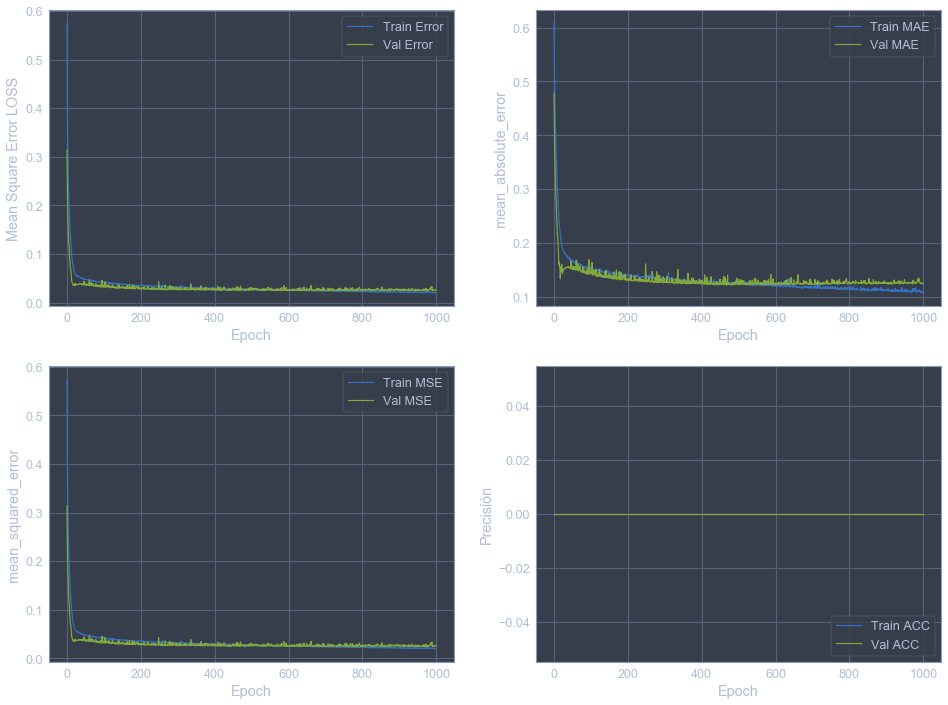

In [20]:
plot_history(history)

Ahora es momento de predecir ya que la red neuronal se encuentra entrenada

In [21]:
y_predic= model.predict(X_test)

Es posible calcular la diferencia entre la prediccion y los datos tomados desde la serie de tiempo

In [22]:
r = y_test - y_predic
ab = abs(r)

Ahora se puede revizar unos datos interesantes

In [23]:
print('Media:', r.mean())
print('Maximo:', ab.max())
print('Minimo:', ab.min())
print('STD:', r.std())

Media: -0.0180731915407136
Maximo: 0.4398534429222931
Minimo: 0.00031081093008586413
STD: 0.16005352829736375


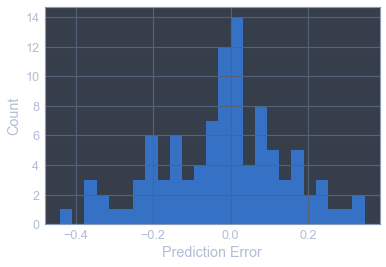

In [24]:
plt.hist(r, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [25]:
Y_inv = y_test*std + mean
Y_pred_inv = y_predic*std + mean

In [26]:
ERR = np.sqrt(mean_squared_error(Y_inv,Y_pred_inv)) 
ERR 

2.478529529828585

In [27]:
print(Y_inv.max())
ERR*100/Y_inv.max()

120.3092497096122


2.060132147620368

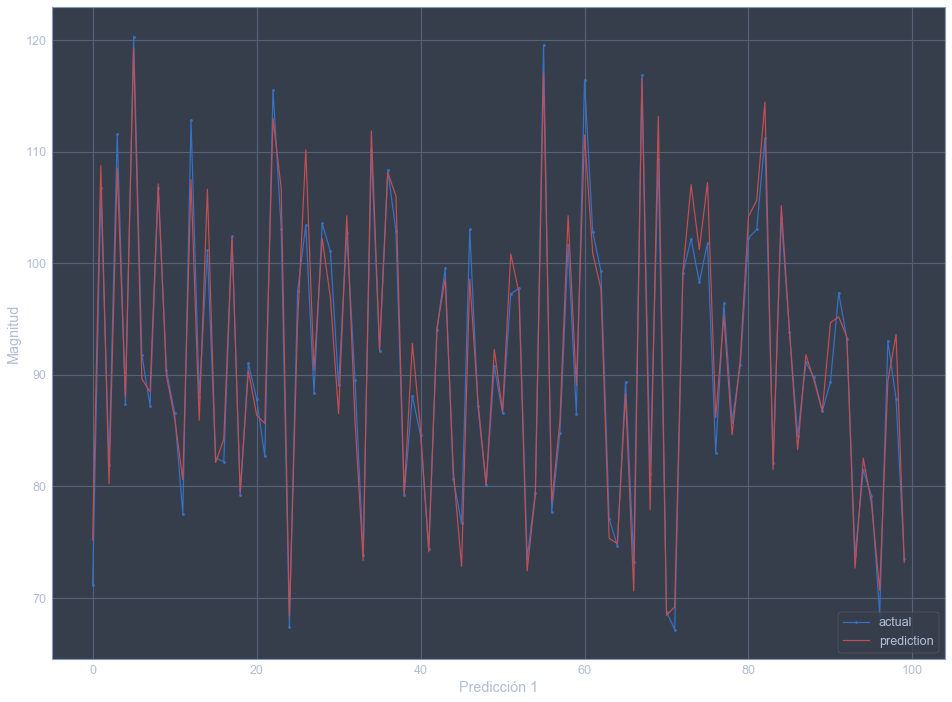

In [28]:
Y_inv = y_test*std + mean
Y_pred_inv = y_predic*std + mean

plt.figure(figsize=(16, 12))

plt.xlabel('Predicción 1')
plt.ylabel('Magnitud')
plt.plot(Y_inv[:, 0],marker='.', label="actual")
plt.plot(Y_pred_inv[:, 0], 'r', label="prediction")
plt.legend(loc="lower right")

plt.show()

<h3>Guardar el modelo entrenado </h3>

In [29]:
#model.save('modelo_serie_electrica3.h5')